### Model
- 3 VGG Blocks
- No regularization
- Optimizer: SGD
- Loss: categorical_crossentropy

### Dataset
- Images cropped and resized
- Original Colorscheme
- Scaled in Generator and resized to 300x300x3

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import SGD

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Multi_Class/train4_small.csv')

In [5]:
df.head()

,filename,labels
0,3f58d128caf6.jpg,glaucoma
1,802b4bfabd52.jpg,md
2,7bcfab1fa2da.jpg,opacity
3,012e91949ec4.jpg,opacity
4,6386346fb595.jpg,opacity


In [6]:
df["labels"].replace({"macular degeneration": "md"}, inplace=True)

In [7]:
df.labels.value_counts()

opacity     500
md          500
glaucoma    500
normal      500
Name: labels, dtype: int64

### ImageGenerator

In [8]:
from sklearn.utils import shuffle 
#df = shuffle(df)

In [9]:
# Directory
indir = '/content/drive/MyDrive/Datensätze/four'

In [10]:
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.25)

In [11]:
train_gen = datagen.flow_from_dataframe(dataframe = df, 
                                        directory = indir, 
                                        x_col = "filename", 
                                        y_col = 'labels',
                                        batch_size = 10, 
                                        seed = 2, 
                                        shuffle = True, 
                                        class_mode = "categorical", 
                                        classes = ['opacity', 'glaucoma','md', 'normal'],
                                        target_size = (300,300),
                                        subset='training')

Found 1500 validated image filenames belonging to 4 classes.


In [12]:
val_gen = datagen.flow_from_dataframe(dataframe = df, 
                                      directory = indir, 
                                      x_col = "filename", 
                                      y_col = 'labels',
                                      batch_size = 10, 
                                      seed = 2, 
                                      shuffle = True,
                                      class_mode = "categorical", 
                                      classes = ['opacity', 'glaucoma','md', 'normal'],
                                      target_size = (300,300),
                                      subset='validation')

Found 500 validated image filenames belonging to 4 classes.


In [13]:
imgs, labels = next(train_gen)

In [14]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    

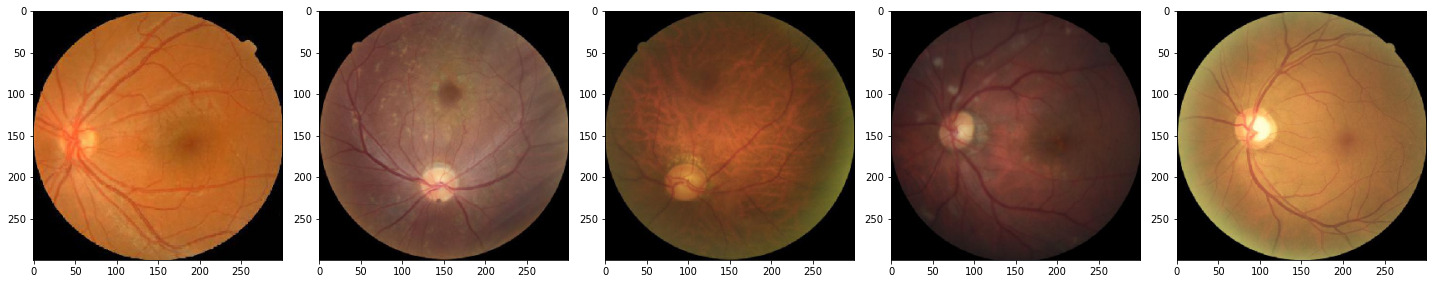

[[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


In [15]:
plotImages(imgs)
print(labels)

### Model

In [16]:
early_stopping = EarlyStopping(patience=5)

In [17]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(300,300,3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(4, activation='softmax'))


In [18]:
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
step_size_train = train_gen.n//train_gen.batch_size
step_size_val = val_gen.n//val_gen.batch_size

In [20]:
history = model.fit(x=train_gen, validation_data=val_gen, steps_per_epoch=step_size_train, 
          validation_steps=step_size_val, epochs=100, callbacks=[early_stopping],verbose=2)

Epoch 1/100
150/150 - 37s - loss: 1.1437 - accuracy: 0.5013 - val_loss: 1.4301 - val_accuracy: 0.3500
Epoch 2/100
150/150 - 14s - loss: 0.9380 - accuracy: 0.6007 - val_loss: 1.1711 - val_accuracy: 0.4580
Epoch 3/100
150/150 - 14s - loss: 0.8259 - accuracy: 0.6600 - val_loss: 1.7324 - val_accuracy: 0.3000
Epoch 4/100
150/150 - 14s - loss: 0.7568 - accuracy: 0.6947 - val_loss: 1.6083 - val_accuracy: 0.3260
Epoch 5/100
150/150 - 14s - loss: 0.6530 - accuracy: 0.7347 - val_loss: 1.3207 - val_accuracy: 0.3580
Epoch 6/100
150/150 - 14s - loss: 0.6324 - accuracy: 0.7513 - val_loss: 1.2923 - val_accuracy: 0.4480
Epoch 7/100
150/150 - 14s - loss: 0.5919 - accuracy: 0.7707 - val_loss: 1.2727 - val_accuracy: 0.5180


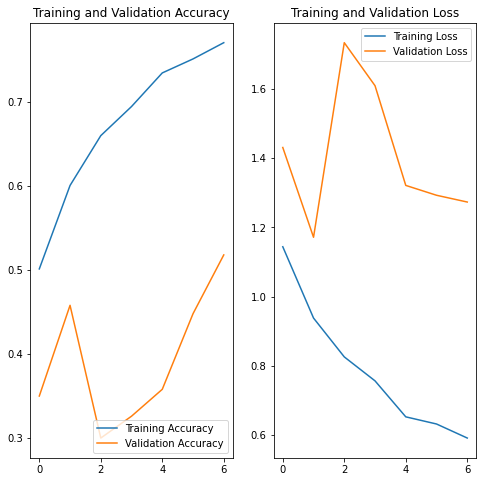

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(7)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model is overfitting